In [1]:
def to_day_of_year(date):
    if date.is_leap_year and date.day_of_year > 60:
        return date.day_of_year-1
    return date.day_of_year


def historical_max_date(row):
    df_MAX10 = df_MAX10y.copy().set_index('DAY OF YEAR')
    df_MAX10 = df_MAX10.loc[row['DAY OF YEAR']]
    df_MAX10 = df_MAX10[(df_MAX10['TMAX'] == df_MAX10['TMAX'].max())]

    return df_MAX10['DATE'].iloc[-1]


def historical_min_date(row):
    df_MIN10 = df_MIN10y.copy().set_index('DAY OF YEAR')
    df_MIN10 = df_MIN10.loc[row['DAY OF YEAR']]
    df_MIN10 = df_MIN10[(df_MIN10['TMIN'] == df_MIN10['TMIN'].min())]

    return df_MIN10['DATE'].iloc[-1]

In [7]:
import pandas as pd
import numpy as np


feb29th = ['2012-02-29', '2016-02-29', '2020-02-29']

df = pd.read_csv("/content/sf_stations/USW00023234.csv", low_memory=False)
df.sort_values('DATE', inplace=True)
df = df.loc[:, ['DATE', 'TMAX', 'TMIN']]
df.drop(index=df[(df['DATE'] == '2012-02-29') | (df['DATE'] == '2016-02-29') | (df['DATE'] == '2020-02-29')].index, inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['TMAX'] = df['TMAX']/10
df['TMIN'] = df['TMIN']/10
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df = df[(df['DATE'] >= '2012') & (df['DATE'] < '2023')]
df['DAY OF YEAR'] = df['DATE'].apply(to_day_of_year)

In [4]:
df_MAX = pd.DataFrame(df[['DATE', 'DAY OF YEAR', 'TMAX']])
df_MIN = pd.DataFrame(df[['DATE', 'DAY OF YEAR', 'TMIN']])


In [5]:
df_MAX10y = df_MAX[df_MAX['DATE'] < '2022']
df_MAX10y_grp = df_MAX10y.groupby(['DAY OF YEAR'], as_index=False)['TMAX'].max()
df_MAX10y_grp['DATE'] = df_MAX10y_grp.apply(lambda r: historical_max_date(r), axis=1)


df_MIN10y = df_MIN[df_MIN['DATE'] < '2022']
df_MIN10y_grp = df_MIN10y.groupby(['DAY OF YEAR'], as_index=False)['TMIN'].min()
df_MIN10y_grp['DATE'] = df_MIN10y_grp.apply(lambda r: historical_min_date(r), axis=1)



df_MAX2022 = df_MAX[df_MAX['DATE'] >= '2022'].reset_index(drop=True)


df_MIN2022 = df_MIN[df_MIN['DATE'] >= '2022'].reset_index(drop=True)

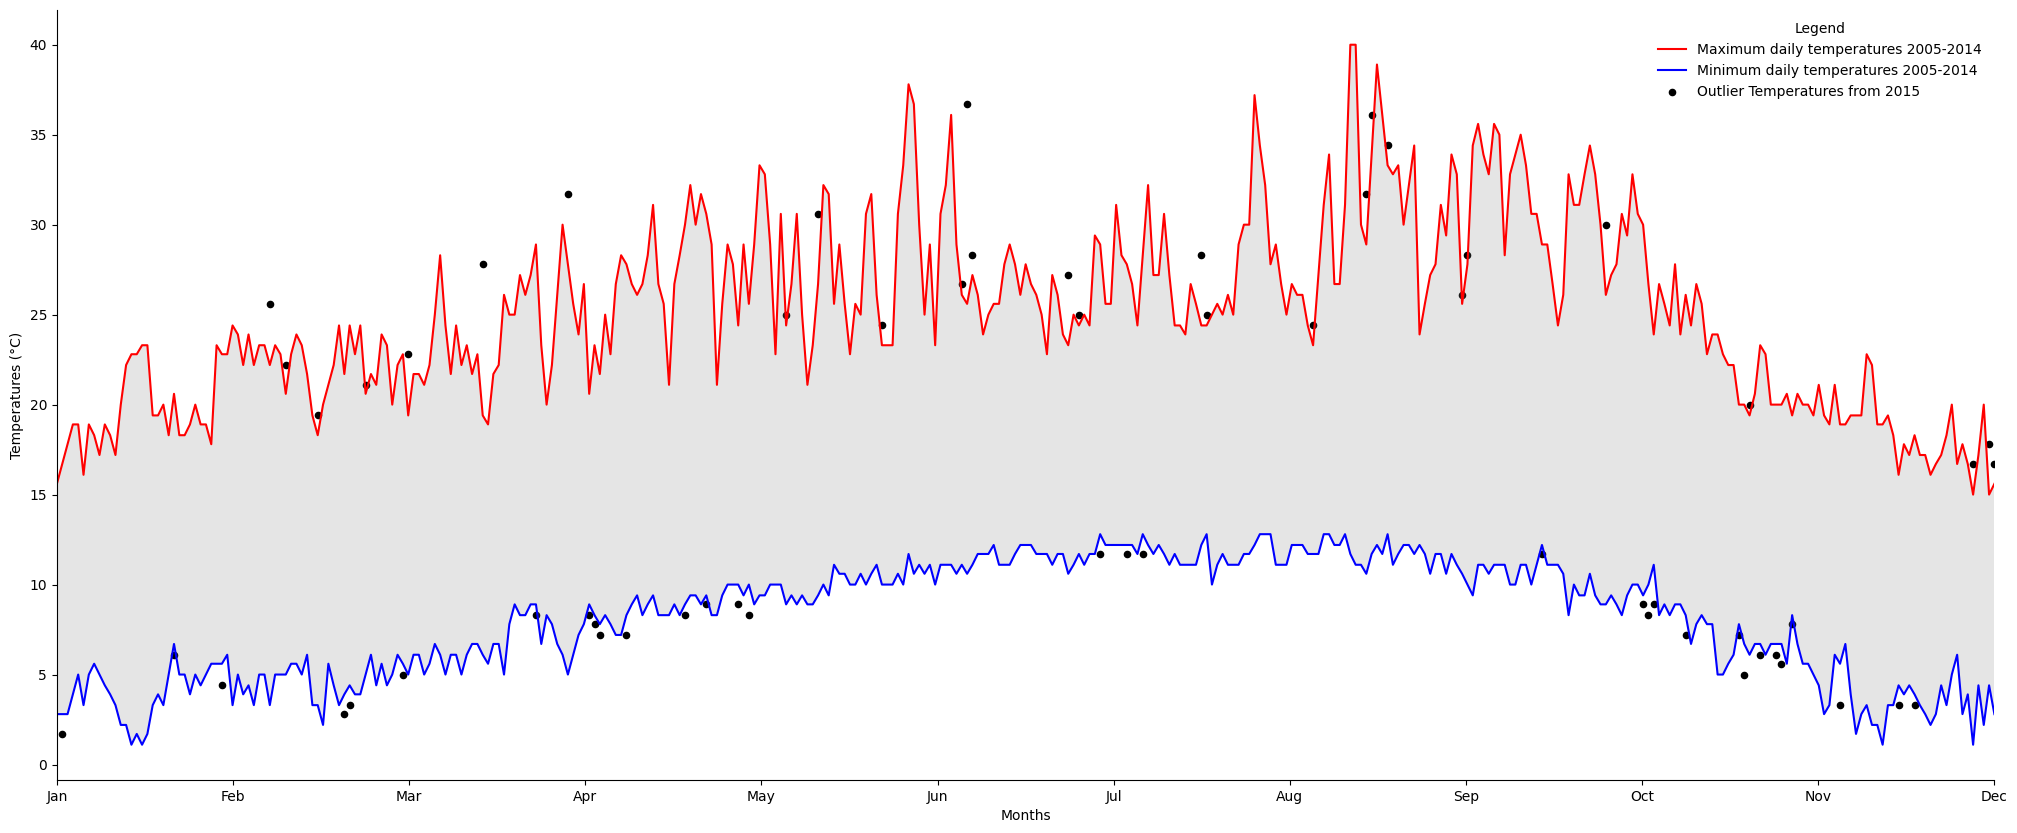

In [6]:
import matplotlib.pyplot as plt
from calendar import month_abbr
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(25,10))

observation_dates = pd.date_range('01-01-2023', periods=365, freq='D').to_series().dt.strftime('%d-%m')

plt.plot(observation_dates, df_MAX10y_grp['TMAX'], '-', color='red', label='Maximum daily temperatures 2005-2014')
plt.plot(observation_dates, df_MIN10y_grp['TMIN'], '-', color='blue', label='Minimum daily temperatures 2005-2014')


lower_2022 = list()
higher_2022 = list()

for i in range(0, 365):
    if df_MAX2022['TMAX'].iloc[i] > df_MAX10y_grp['TMAX'].iloc[i]:
        higher_2022.append(df_MAX2022.iloc[i])
    if df_MIN2022['TMIN'].iloc[i] < df_MIN10y_grp['TMIN'].iloc[i]:
        lower_2022.append(df_MIN2022.iloc[i])


higher_2015 = pd.DataFrame(higher_2022, index=np.arange(0, len(higher_2022), dtype='int'))
lower_2015 = pd.DataFrame(lower_2022, index=np.arange(0, len(lower_2022), dtype='int'))

plt.scatter(higher_2015['DAY OF YEAR']-1, higher_2015['TMAX'], s=20, color='black', label='Outlier Temperatures from 2015')
plt.scatter(lower_2015['DAY OF YEAR']-1, lower_2015['TMIN'], s=20, color='black')


ax = plt.gca()
ax.fill_between(range(0, 365), df_MAX10y_grp['TMAX'], df_MIN10y_grp['TMIN'], facecolor='gray', alpha=0.2)


ax.xaxis.set_major_locator(plt.LinearLocator(numticks=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_xlim((0, 364))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Months')
ax.set_ylabel('Temperatures (°C)')

plt.legend(title='Legend', loc=1, frameon=False);